# Roads SceneSegmentation 

In [1]:
# !pip install imantics --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import json
import os
import imantics
from PIL import Image
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
base_dir = 'C:\\Users\\Niwaas\\Road Scene Segmentation'
images_dir = f'{base_dir}/images' 
masks_dir = f'{base_dir}/masks' 

In [4]:
images_listdir = os.listdir(images_dir)[0:120]
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [5]:
image_size=512
input_image_size=(512,512)

In [6]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

# Input images 

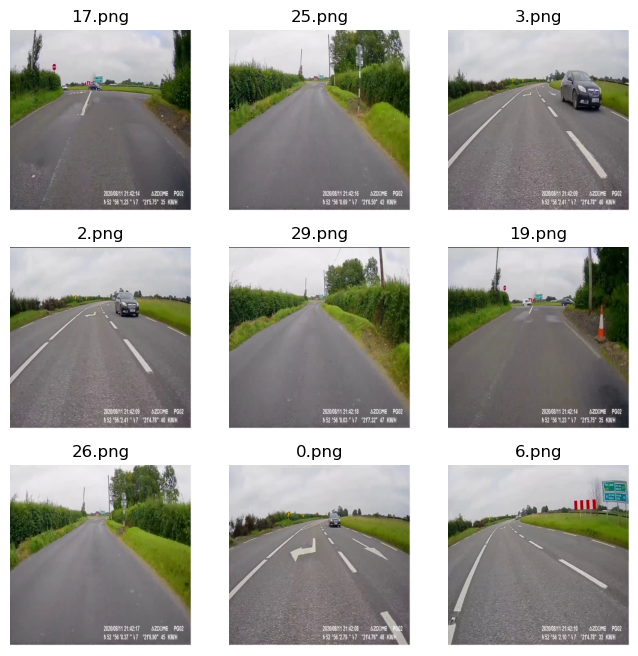

In [7]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (8,8))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

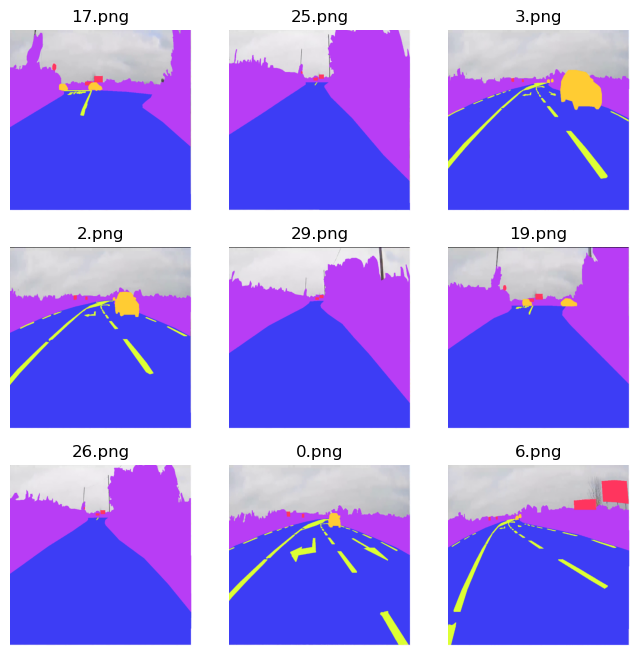

In [8]:
fig, ax = plt.subplots(rows, cols, figsize = (8,8))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file = random_images[i][0:-4]+'.png'
        img = read_image(f"{masks_dir}/{file}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

In [9]:
MASKS=np.zeros((1,image_size, image_size, 3),dtype=np.uint8) 
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:81]): ##the smaller, the faster
    #print(j)
    image = read_image(f"{images_dir}/{file}")
    image_ex = np.expand_dims(image, axis=0)
    IMAGES = np.vstack([IMAGES, image_ex])
    
    file2=file[0:-4]+'.png'
    mask = read_image(f"{masks_dir}/{file2}")
    mask_ex = np.expand_dims(mask, axis=0)    
    MASKS = np.vstack([MASKS, mask_ex])


In [10]:
images=np.array(IMAGES)[1:81]
masks=np.array(MASKS)[1:81]
print(images.shape,masks.shape)

(31, 512, 512, 3) (31, 512, 512, 3)


In [11]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [12]:
print(len(images_train), len(masks_train))
print(len(images_test), len(masks_test))

18 18
13 13


# U-Net

In [13]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation="sigmoid")(decode4) #####

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0

 chNormalization)                                                                                 
                                                                                                  
 activation_8 (Activation)   (None, 32, 32, 1024)         0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 32, 32, 1024)         9438208   ['activation_8[0][0]']        
                                                                                                  
 batch_normalization_9 (Bat  (None, 32, 32, 1024)         4096      ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activatio

 )                                                                   'activation_1[0][0]']        
                                                                                                  
 conv2d_16 (Conv2D)          (None, 512, 512, 64)         73792     ['concatenate_3[0][0]']       
                                                                                                  
 batch_normalization_16 (Ba  (None, 512, 512, 64)         256       ['conv2d_16[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 512, 512, 64)         0         ['batch_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_17

# Callback

In [14]:
#!rm -rf output_masks

In [15]:
from tensorflow import keras

class SaveMaskImagesCallback(keras.callbacks.Callback):
    def __init__(self, output_dir, images, masks, save_every_n_epochs=4):
        super(SaveMaskImagesCallback, self).__init__()
        self.output_dir = output_dir
        self.images = images
        self.masks = masks
        self.save_every_n_epochs = save_every_n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_every_n_epochs == 0:
            predictions = self.model.predict(self.images)
            for i, pred_mask in enumerate(predictions):
                output_path = os.path.join(self.output_dir, f"mask_{i:02d}_ep_{epoch + 1:03d}.png")
                pred_mask = (pred_mask * 255).astype(np.uint8)
                keras.preprocessing.image.save_img(output_path, pred_mask)

output_directory = "output_masks"  
os.makedirs(output_directory, exist_ok=True)
mask_callback = SaveMaskImagesCallback(output_directory, images_train, masks_train)

# Train

In [16]:
unet_result = unet_model.fit(
    images_train, masks_train, 
    validation_split=0.2, batch_size=4, epochs=5,
    callbacks=[mask_callback]
)

Epoch 1/5
4/4 [==============================] - 204s 40s/step - loss: -86.5717 - accuracy: 0.4618 - val_loss: 196177.6406 - val_accuracy: 0.3862
Epoch 2/5
4/4 [==============================] - 151s 36s/step - loss: -207.7089 - accuracy: 0.5353 - val_loss: 2335640.0000 - val_accuracy: 0.2541
Epoch 3/5
4/4 [==============================] - 155s 38s/step - loss: -264.8257 - accuracy: 0.5457 - val_loss: 188658496.0000 - val_accuracy: 0.1552
Epoch 4/5
4/4 [==============================] - 211s 57s/step - loss: -312.0332 - accuracy: 0.5708 - val_loss: 111949872.0000 - val_accuracy: 0.0243
Epoch 5/5
4/4 [==============================] - 151s 37s/step - loss: -340.4394 - accuracy: 0.5730 - val_loss: 175837712.0000 - val_accuracy: 0.0242


    unet_result = unet_model.fit(
        images_train, masks_train, 
        validation_split = 0.2, batch_size = 4, epochs = 75)

# Predict

In [17]:
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 38s 38s/step


In [18]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx))
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet*0.9)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [19]:
r1,r2,r3,r4=0.7,0.8,0.9,0.99

In [20]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

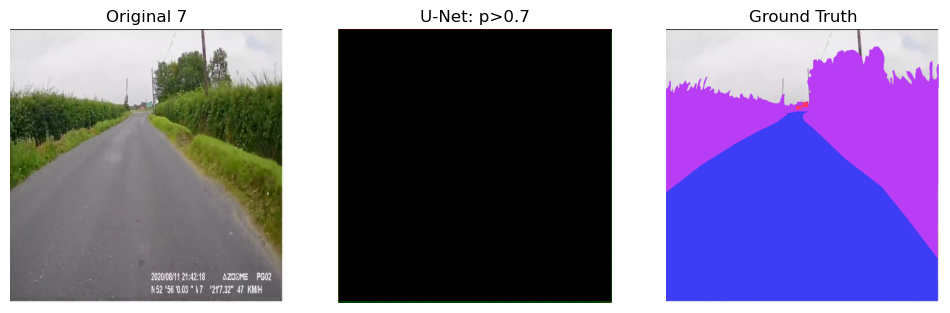

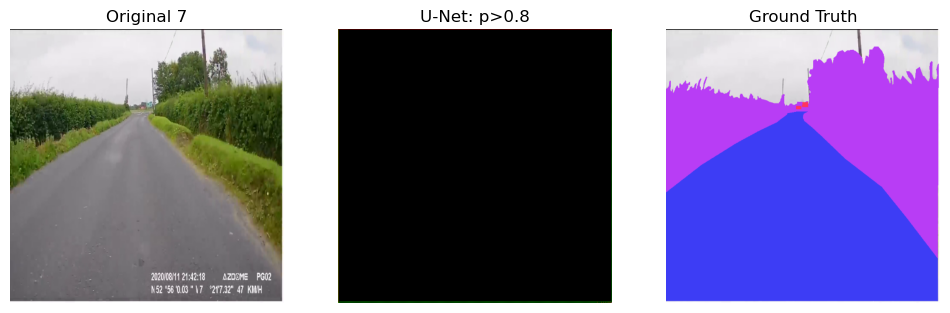

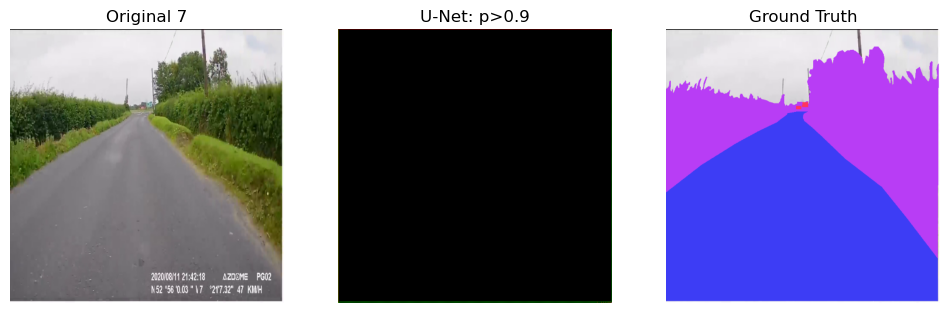

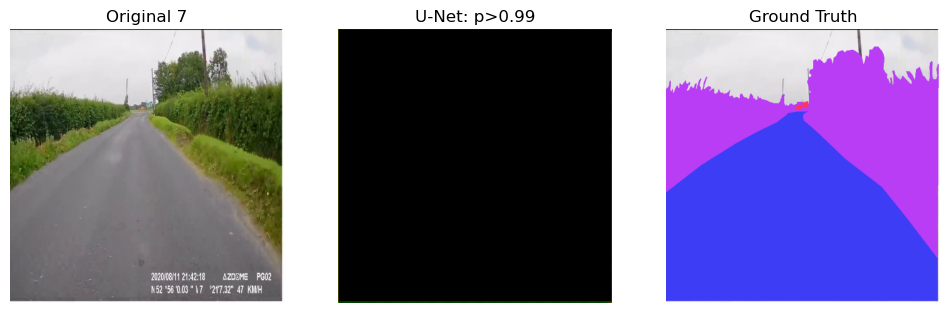

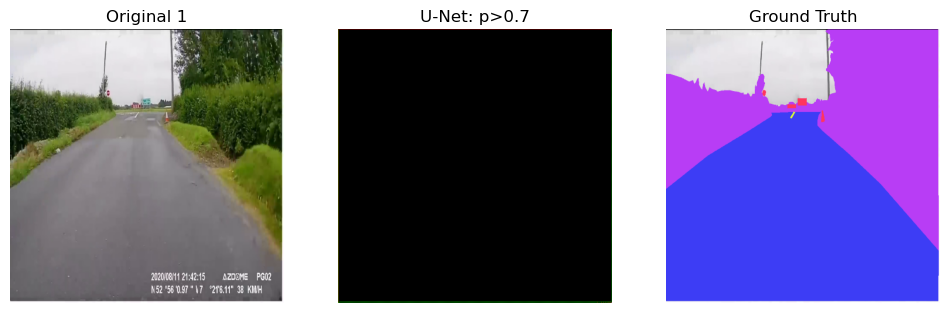

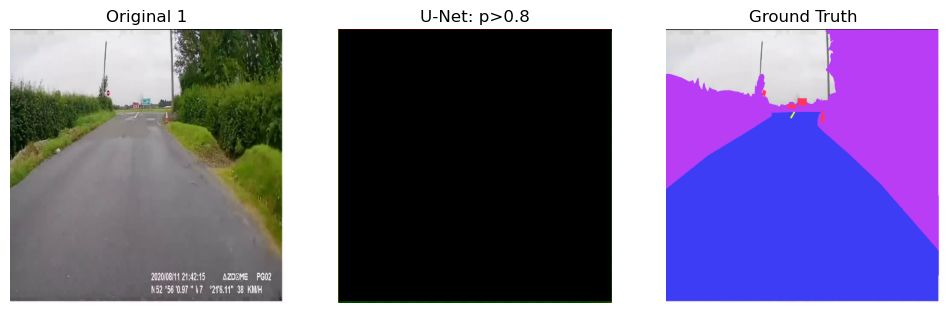

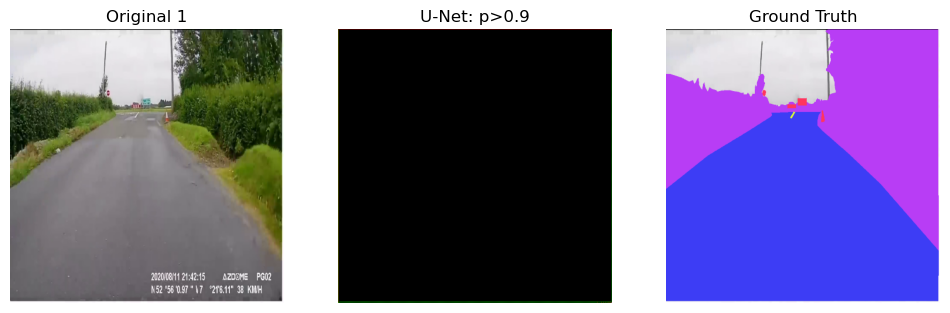

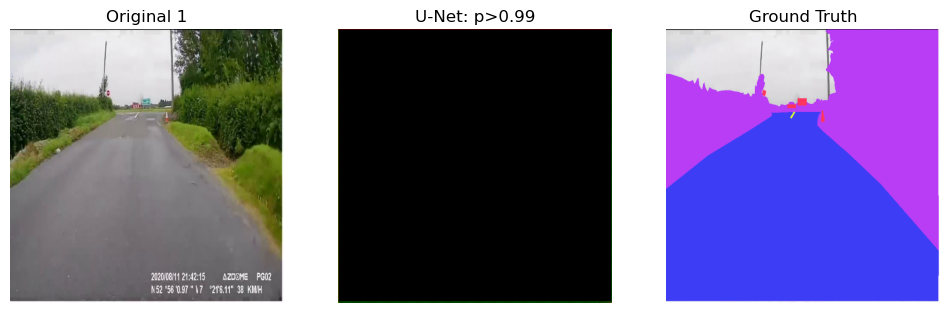

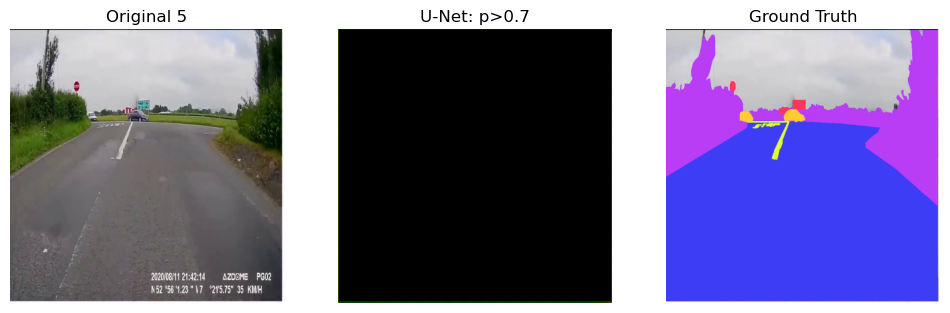

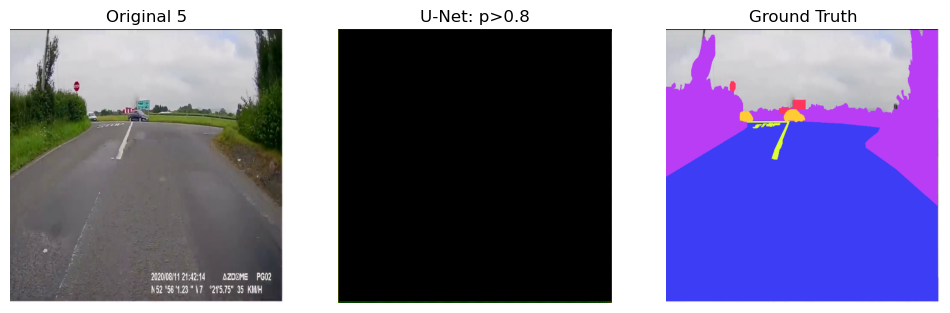

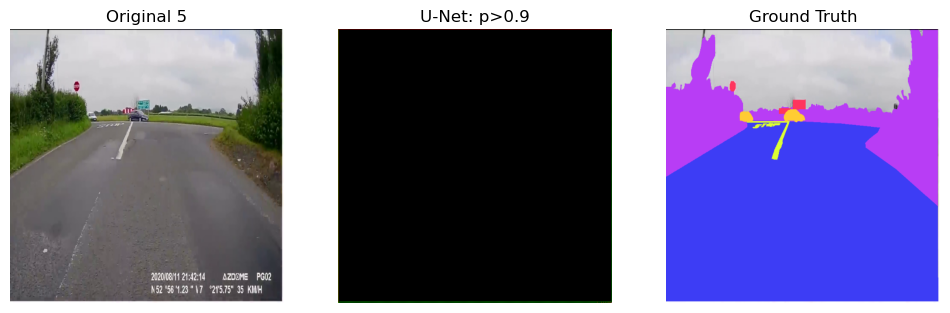

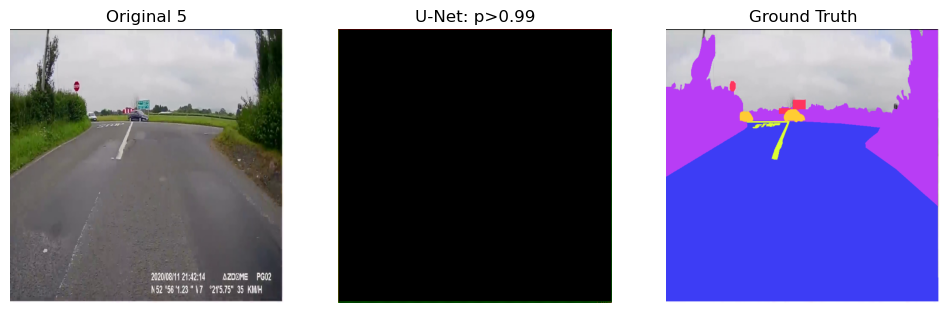

In [21]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()